In [63]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np
from PIL import Image
import math
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
# General
import warnings
warnings.filterwarnings("ignore")
import datetime
from time import time
import pandas as pd
import os
import numpy as np
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

# OpenCV
import cv2

# ScikitLearn for Data Splitting
from sklearn.model_selection import train_test_split, GroupKFold, StratifiedKFold

# Albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

# Pytorch
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.ops import nms

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
pd.set_option('display.max_colwidth', None)


In [64]:
VALIDATION_IMAGES = 200
TRAIN_IMAGES = 2000

IMAGE_SIZE = 224
GRID_SIZE = 7
BOX_SIZE = 1 #originally 2 boxes -> choose the one with the highest iou => we will not do in here
NUM_CLASS = 1
BATCH_SIZE = 16

In [65]:
DATA_PATH = '../data/LISATrafficLightDataset/'

DAY_TRAIN_PATH = '../data/LISATrafficLightDataset/Annotations/Annotations/dayTrain/'


In [66]:
train_day = []
for clipName in tqdm(sorted(os.listdir(DAY_TRAIN_PATH))):
    if 'dayClip' not in clipName:
        continue
    df = pd.read_csv(os.path.join(DAY_TRAIN_PATH,clipName,'frameAnnotationsBOX.csv'),sep=';')
    train_day.append(df)
train_day_df = pd.concat(train_day,axis=0)
train_day_df['isNight'] = 0

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 113.62it/s]


In [67]:
df = train_day_df


In [68]:
def changeFilename(x):
    filename = x.Filename
    
    splitted = filename.split('/')
    clipName = splitted[-1].split('--')[0]
    return os.path.join(DATA_PATH,f'dayTrain/dayTrain/{clipName}/frames/{splitted[-1]}')

df['Filename'] = df.apply(changeFilename,axis=1)

In [69]:
df = df.drop(['Origin file','Origin track','Origin track frame number','isNight','Origin frame number','Annotation tag'],axis=1)

In [70]:
df.columns = ['filename','x_min','y_min','x_max','y_max']
df['label'] = 1


In [71]:
df

,filename,x_min,y_min,x_max,y_max,label
0,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,698,333,710,358,1
1,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00000.jpg,846,391,858,411,1
2,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,698,337,710,357,1
3,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00001.jpg,847,390,859,410,1
4,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00002.jpg,698,331,710,356,1
...,...,...,...,...,...,...
7974,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--02160.jpg,660,322,672,342,1
7975,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--02160.jpg,777,351,792,376,1
7976,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--02160.jpg,838,174,868,234,1
7977,../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--02160.jpg,987,213,1014,263,1


In [72]:
bb_box = (df[['x_min','y_min','x_max','y_max','label']].values)

In [73]:
images = (df[['filename']].values)

In [74]:
images_list = []
for image in images:
    images_list.append(image[0])
images = images_list


In [75]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, bb_box, test_size=0.15, random_state=42)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)



# X_train = X_train.tolist()
# X_val = X_val.tolist()
# y_train = y_train.tolist()
# y_val = y_val.tolist()

In [76]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, shuffle=False):
        self.images = images
        self.labels = labels
        self.shuffle = shuffle
    
    def __len__(self):
        return (np.ceil(len(self.images) / int(BATCH_SIZE))).astype(int)
    
    def __getitem__(self, idx):
        batch_x = self.images[idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # images path
        batch_y = self.labels[idx * BATCH_SIZE : (idx + 1) * BATCH_SIZE] # raw label

        train_image, train_label = [], []
        for i in range(0, len(batch_x)):
            img_path, label = batch_x[i], batch_y[i]
            image, label_matrix = self.read(img_path, label) #actual image array (IMAGE_SIZE, IMAGE_SIZE, 3) (GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + CLASS) 
            train_image.append(image)
            train_label.append(label_matrix)
        
        if self.shuffle:
            indices = tf.range(start=0, limit=tf.shape(train_image)[0], dtype=tf.int32)
            idx = tf.random.shuffle(indices)
            train_image = tf.gather(train_image, idx)
            train_label = tf.gather(train_label, idx)

        return np.array(train_image, dtype=np.float32), np.array(train_label, dtype=np.float32)
    
    def read(self, img_path, label):
        image = cv.imread(img_path)
        h, w = image.shape[0:2]
        image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = image / 255.

#         label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE + NUM_CLASS])
        label_matrix = np.zeros([GRID_SIZE, GRID_SIZE, 5 * BOX_SIZE])

#         for l in label:
#         l = l.split(',')
#         l = np.array(l, dtype=int)

        xmin, ymin, xmax, ymax = label[0] / w, label[1] / h, label[2] / w, label[3] / h # [0, 1]

        x, y = (xmin + xmax) / 2, (ymin + ymax) / 2
        w, h = xmax - xmin, ymax - ymin

        #convert x, y relative to the cell
        i, j = int(GRID_SIZE * y), int(GRID_SIZE * x)
        x = GRID_SIZE * x - j # 7 * [0,1] = [0, 7] e.g: 6.43 - int(6.43) = 0.43 => relative to the cell
        y = GRID_SIZE * y - i
        label_matrix[i, j] = [x, y, w, h, 1]
#             if l[4] == 0:
#                 label_matrix[i, j] = [x, y, w, h, 1, 1, 0]
#             if l[4] == 1:
#                 label_matrix[i, j] = [x, y, w, h, 1, 0, 1]
        return image, label_matrix


In [77]:
trainingDataGenerator = DataGenerator(X_train, y_train)
validationDataGenerator = DataGenerator(X_val, y_val)
testDataGenerator = DataGenerator(X_test, y_test)


In [78]:
def TestPrint(image, label):
    fig, ax = plt.subplots()
    ax.set_axis_off()

    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if label[i][j][4] > 0.5:
                print(label[i][j])
                x, y, w, h = label[i][j][:4]

                xmax = int(((x + j) / GRID_SIZE * IMAGE_SIZE) + (w * IMAGE_SIZE) / 2)
                xmin = int(((x + j) / GRID_SIZE * IMAGE_SIZE) - (w * IMAGE_SIZE) / 2)
                ymax = int(((y + i) / GRID_SIZE * IMAGE_SIZE) + (h * IMAGE_SIZE) / 2)
                ymin = int(((y + i) / GRID_SIZE * IMAGE_SIZE) - (h * IMAGE_SIZE) / 2)

#                 className = classArray[tf.argmax(label[i][j][5:], axis=-1)]
#                 cv.putText(image, className, (xmin, ymax + 10), cv.FONT_HERSHEY_COMPLEX_SMALL, 1, (255, 255, 255))
                cv.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 0, 255), 1)

    ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.2902344  0.65052086 0.01171875 0.02604167 1.        ]


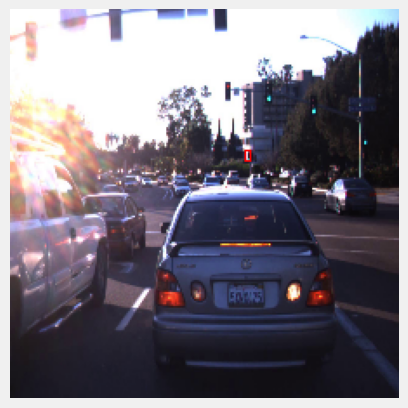

In [79]:
x_train, y_train = trainingDataGenerator.__getitem__(17)
idx = 1
TestPrint(x_train[idx], y_train[idx])

In [80]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Reshape
import cv2
import numpy as np

# Load EfficientNetB0 model
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=x_train[0].shape)

for layer in base_model.layers:
    layer.trainable = False

# Add two more convolutional layers
x = base_model.output
x = Conv2D(filters=256, kernel_size=1, activation='relu', padding='same')(x)
x = Conv2D(filters=5, kernel_size=1, strides=(1, 1), padding='same')(x)
# x = Reshape(target_shape=(7, 7, 5))(x)

# Create a new model with modified output shape
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block3b_b

 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_se_squeeze (GlobalAver  (None, 480)         0           ['block4b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_se_reduce (Conv2D)     (None, 1, 1, 20)     9620        ['block5a_se_reshape[0][0]']     
          

                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6b_add[0][0]']            
          

                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_expand_activation (Act  (None, 7, 7, 1152)  0           ['block7a_expand_bn[0][0]']      
 ivation) 

In [81]:
#YOLO LOSS !!!
def yoloLoss(y_true, y_pred):
    coordLoss = CoordLoss(y_true, y_pred)
    confidenceLoss = ConfidenceLoss(y_true, y_pred)
#     classLoss = ClassLoss(y_true, y_pred)

    return coordLoss + confidenceLoss #+ 5 * classLoss

def CoordLoss(y_true, y_pred):
    #find if it exist an object in the grid
    existsObject = tf.expand_dims(y_true[..., 4], -1)

    xy_pred = existsObject * y_pred[..., 0:2]
    xy_true = existsObject * y_true[..., 0:2]

    wh_pred = existsObject * tf.math.sign(y_pred[..., 2:4]) * tf.sqrt(tf.math.abs(y_pred[..., 2:4])) #if it's linear (-inf, inf)
    wh_true = existsObject * tf.sqrt(y_true[..., 2:4])

    coordLoss = tf.reduce_sum(tf.math.square(wh_pred - wh_true))
    coordLoss += tf.reduce_sum(tf.math.square(xy_pred - xy_true))

    return coordLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

def ConfidenceLoss(y_true, y_pred):
    existsObject = tf.expand_dims(y_true[..., 4], -1) ## MOZE SA VYMAZAT RIADOK 

    confidenceLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 4:5] - y_pred[..., 4:5])))
    confidenceLoss += 0.5*tf.reduce_sum(tf.math.square((1 - existsObject) * (y_true[..., 4:5] - y_pred[..., 4:5])))

    return confidenceLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

# def ClassLoss(y_true, y_pred):
#     existsObject = tf.expand_dims(y_true[..., 4], -1)

#     classLoss = tf.reduce_sum(tf.math.square(existsObject * (y_true[..., 5:] - y_pred[..., 5:])))
#     return classLoss / tf.cast(tf.math.count_nonzero(existsObject), dtype=tf.float32) #mean, but it's fine if we don't

In [82]:
model.compile(loss = yoloLoss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), metrics=[CoordLoss, ConfidenceLoss,"accuracy"]) 


In [83]:
model.fit(  x = trainingDataGenerator,
            validation_data = (validationDataGenerator),
            epochs = 1,
            )

361/361 [==============================] - 208s 559ms/step - loss: 126.2812 - CoordLoss: 1.5586 - ConfidenceLoss: 124.4648 - accuracy: 0.1928 - val_loss: 1.1045 - val_CoordLoss: 0.2801 - val_ConfidenceLoss: 0.8249 - val_accuracy: 0.8557


In [ ]:
# idx = 1
# TestPrint(x_train[idx], y_train[idx])

1/1 [==============================] - 0s 67ms/step


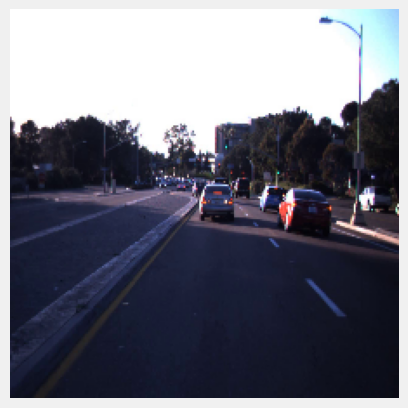

In [87]:
# for i in range(9):
    
# image = cv.imread('../data/LISATrafficLightDataset/dayTrain/dayTrain/dayClip1/frames/dayClip1--00210.jpg')
# image = cv.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

x_test, y_test = testDataGenerator.__getitem__(25)
TestPrint(x_test[0], model.predict(np.expand_dims(x_test[0], 0))[0])